lenet.index does not exist, this will be created
lenet.meta does not exist, this will be created
lenet.data-00000-of-00001 does not exist, this will be created

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


()

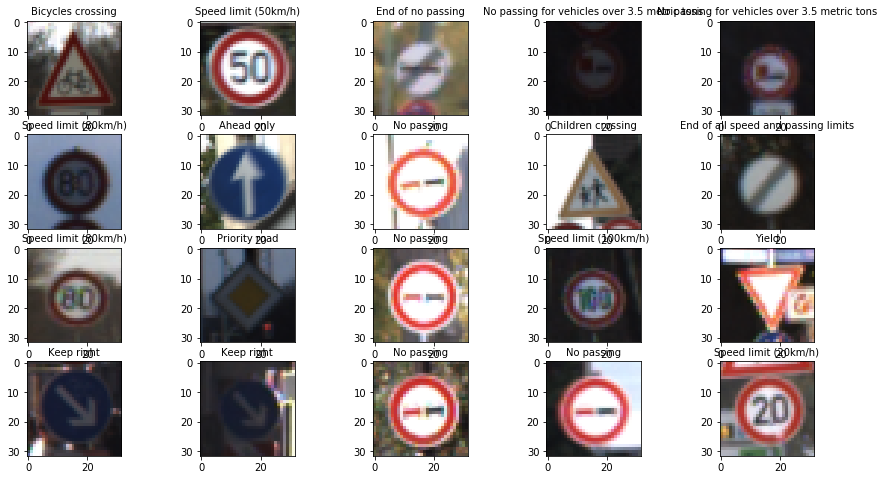

In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
from tensorflow.examples.tutorials.mnist import input_data
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


#Delete previous saved modified lenet models of there are any. THis resolves an issue tha occurs if these files already exist

if os.path.exists("lenet.index"):
  os.remove("lenet.index")
  print("Current lenet.index has been deleted, this will be recreated")
else:
  print("lenet.index does not exist, this will be created")

if os.path.exists("lenet.meta"):
  os.remove("lenet.meta")
  print("Current lenet.meta has been deleted, this will be recreated")
else:
  print("lenet.meta does not exist, this will be created")


if os.path.exists("lenet.data-00000-of-00001"):
  os.remove("lenet.data-00000-of-00001")
  print("Current lenet.meta has been deleted, this will be recreated")
else:
  print("lenet.data-00000-of-00001 does not exist, this will be created")

#Load training, validation and testing files

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#verify data from files are of expected length 

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

#setup number of Epochs and batchsize for operation.

EPOCHS = 60
BATCH_SIZE = 20

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# dtermine the shape of an traffic sign image?
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset.
n_classes = 43

# Printing out all relavant information before processing.
print("\nNumber of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


### Training my model using the following architecture.
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation and dropout.
    conv1 = tf.nn.dropout((tf.nn.relu(conv1)), 0.9, noise_shape=None, seed=1, name=None)


    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1 = tf.nn.dropout((conv1), 0.99, noise_shape=None, seed=None, name=None)
    

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2 = tf.nn.dropout((conv2), 0.1, noise_shape=None, seed=None, name=None)
    

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    tf.nn.dropout((conv2), 0.99, noise_shape=None, seed=None, name=None)
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    tf.nn.dropout((flatten(conv2)), 0.9, noise_shape=None, seed=1, name=None)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout((tf.matmul(fc0, fc1_W) + fc1_b), 0.99, noise_shape=None, seed=1, name=None)
    
    # SOLUTION: Activation & dropout
    #fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout((tf.nn.relu(fc1)), 0.99, noise_shape=None, seed=1, name=None)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation & Dropout
    fc2 = tf.nn.dropout((tf.nn.relu(fc2)), 0.99, noise_shape=None, seed=5, name=None)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Calculate and report the accuracy on the training and validation set.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def plot_signs(signs, nrows = 1, ncols=1, labels=None):   
    fig, axs = plt.subplots(ncols, nrows, figsize=(15, 8))
    axs = axs.ravel()
    for index, title in zip(range(len(signs)), signs):
        axs[index].imshow(signs[title])
        axs[index].set_title(labels[index], fontsize=10)
    return()


def normalize_image(image):
    return (image - 128.) / 128.
   

def gray_scale(image):
# Convert to grayscale
    gray_scale_image = np.sum(image/3, axis=3, keepdims=True)
    return gray_scale_image


### Load the images and plot them here.

sign_text = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mystring','S55')], delimiter=',')

number_of_images_to_display = 20
signs = {}
labels = {}
for i in range(number_of_images_to_display):
    index = random.randint(0, n_train-1)
    labels[i] = sign_text[y_train[index]][1].decode('ascii')
    signs[i] = X_train[index]    
plot_signs(signs, 5, 4, labels)

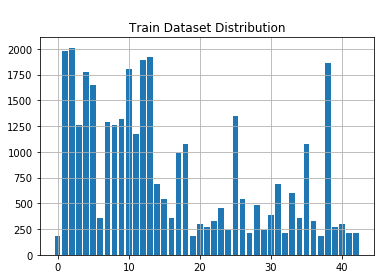

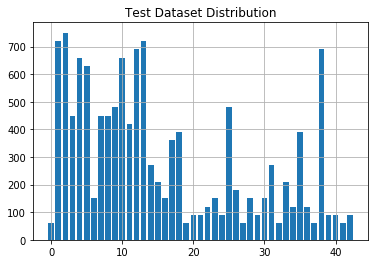

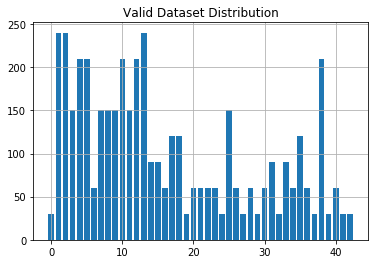

Please restart Kernel if error occurs here
Training...

EPOCH 1 ...
Validation Accuracy = 0.857

EPOCH 2 ...
Validation Accuracy = 0.904

EPOCH 3 ...
Validation Accuracy = 0.905

EPOCH 4 ...
Validation Accuracy = 0.920

EPOCH 5 ...
Validation Accuracy = 0.916

EPOCH 6 ...
Validation Accuracy = 0.939

EPOCH 7 ...
Validation Accuracy = 0.913

EPOCH 8 ...
Validation Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.934

EPOCH 10 ...
Validation Accuracy = 0.926

EPOCH 11 ...
Validation Accuracy = 0.917

EPOCH 12 ...
Validation Accuracy = 0.925

EPOCH 13 ...
Validation Accuracy = 0.928

EPOCH 14 ...
Validation Accuracy = 0.936

EPOCH 15 ...
Validation Accuracy = 0.930

EPOCH 16 ...
Validation Accuracy = 0.939

EPOCH 17 ...
Validation Accuracy = 0.928

EPOCH 18 ...
Validation Accuracy = 0.924

EPOCH 19 ...
Validation Accuracy = 0.935

EPOCH 20 ...
Validation Accuracy = 0.945

EPOCH 21 ...
Validation Accuracy = 0.941

EPOCH 22 ...
Validation Accuracy = 0.930

EPOCH 23 ...
Validation Accur

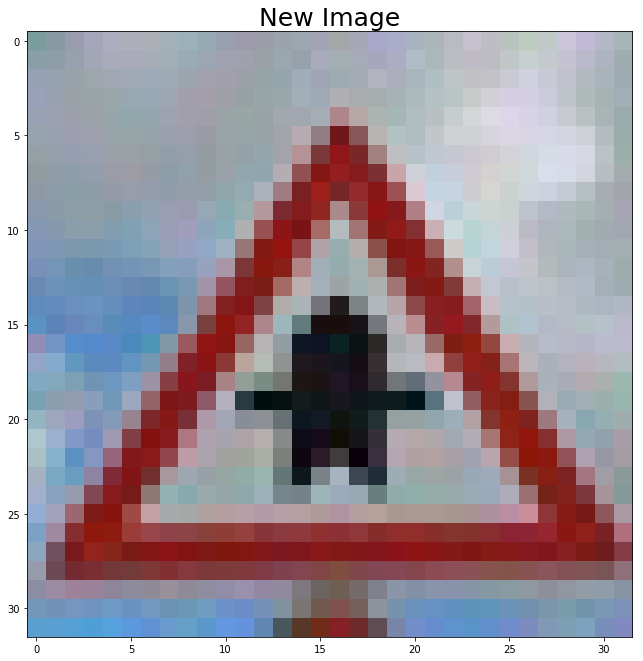

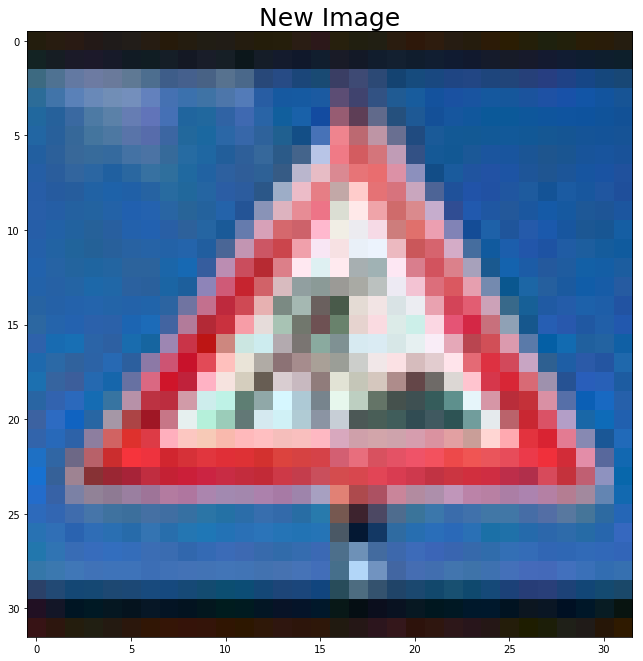

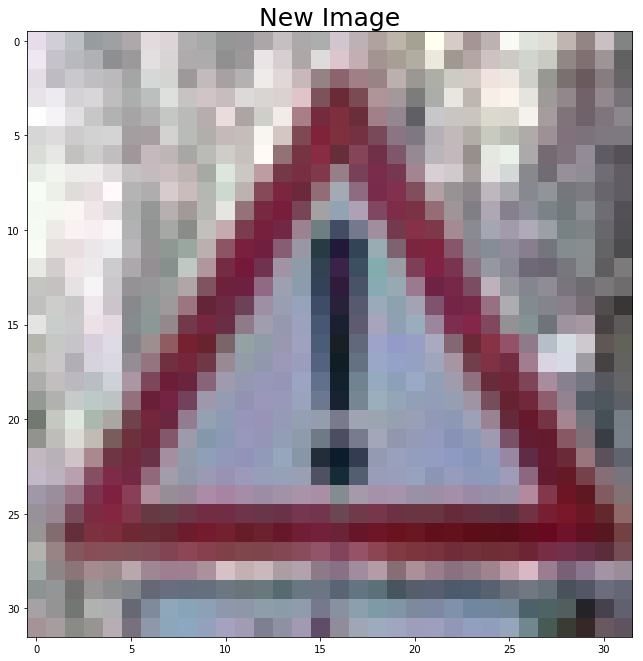

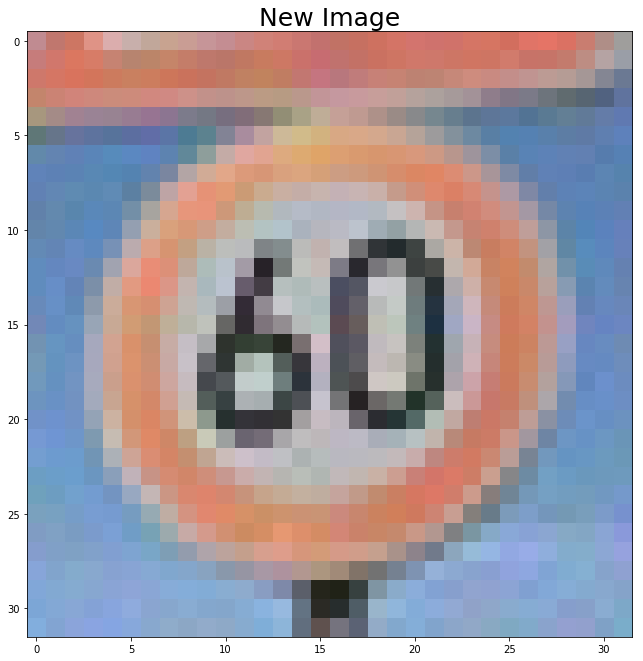

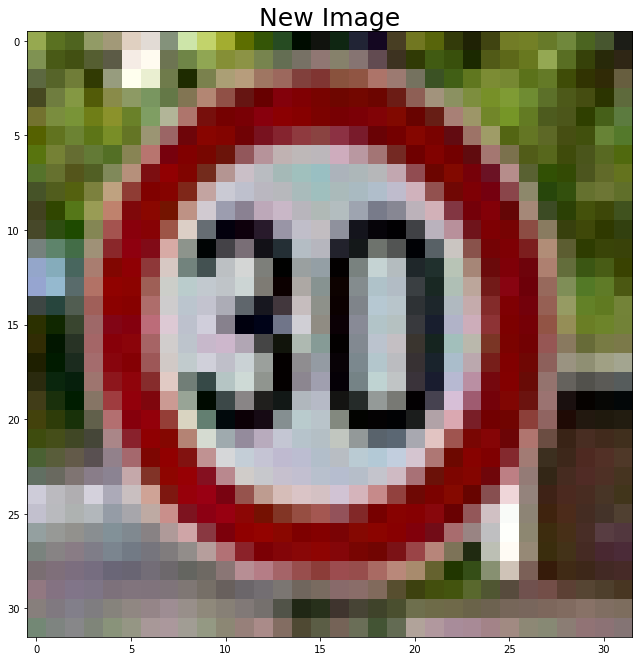

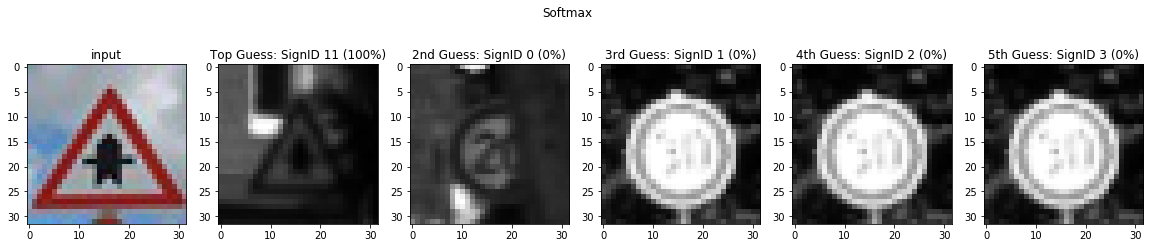

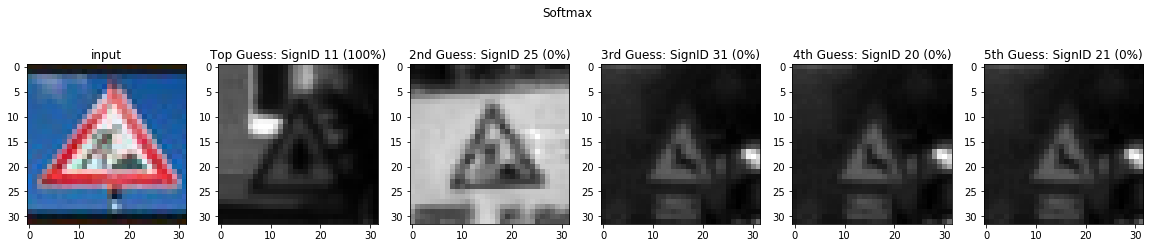

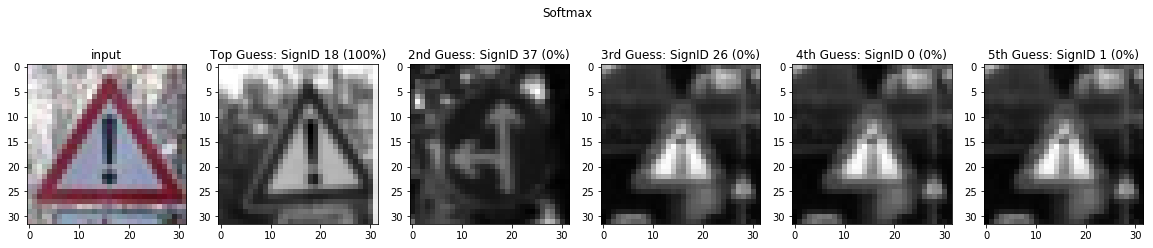

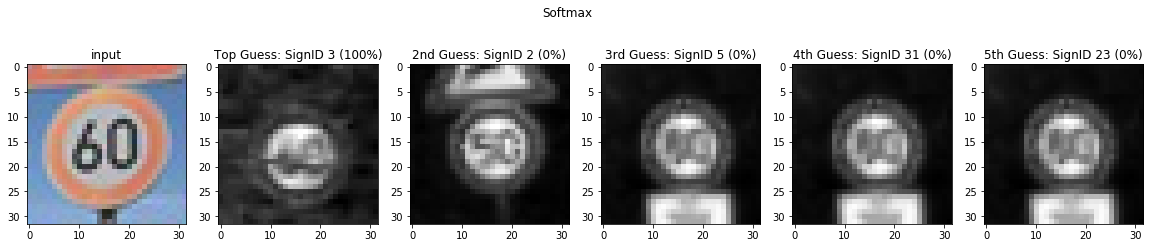

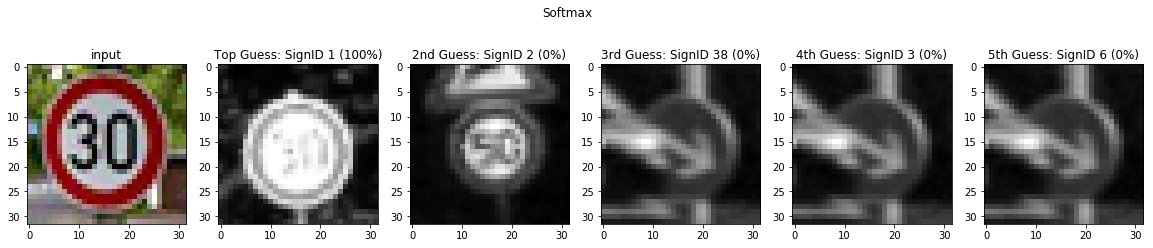

In [2]:
# Finding/Displaying Distribution of unique elements in train, test and validation arrays
      
train_unique, counts_train = np.unique(y_train, return_counts=True)
plt.bar(train_unique, counts_train)
plt.grid()
plt.title("\nTrain Dataset Distribution")
plt.show()

test_unique, counts_test = np.unique(y_test, return_counts=True)
plt.bar(test_unique, counts_test)
plt.grid()
plt.title("Test Dataset Distribution")
plt.show()

valid_unique, counts_valid = np.unique(y_valid, return_counts=True)
plt.bar(valid_unique, counts_valid)
plt.grid()
plt.title("Valid Dataset Distribution")
plt.show()


print("Please restart Kernel if error occurs here")

### Pre-processing pipeline

#Normalize images
X_train = normalize_image(X_train) 
X_valid = normalize_image(X_valid) 
X_test = normalize_image(X_test)

#Gray Scale images
X_train = gray_scale(X_train) 
X_valid = gray_scale(X_valid) 
X_test = gray_scale(X_test)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)


rate = 0.00065

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
   
    
### Calculating the accuracy for these 5 new images in the lines of code below

### Loading new images downloaded of the web and plotting them

test_images = glob.glob('test_images/test*.jpg')

global X_test_new
X_test_new = []

for image in test_images:
    img=mpimg.imread(image)
    f, (ax) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax.imshow(img)
    ax.set_title('New Image', fontsize=25)
    X_test_new.append(img)
    
X_test_new = np.asarray(X_test_new)

### Pre-processing pipeline for new images

#Normalize images
X_test_new = normalize_image(X_test_new)

#Gray Scale images
X_test_new = gray_scale(X_test_new)


### Calculating the accuracy for these 5 new images. 

real_labels = [11, 25, 18, 3, 1] 

with tf.Session() as sess:
    print("Testing...")
    sess.run(tf.global_variables_initializer())
    train_run_saver = tf.train.import_meta_graph('lenet.meta')
    train_run_saver.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_new, real_labels)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))
    
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_test_new})
    my_top_k = sess.run(top_k, feed_dict={x: X_test_new})

    
global softmax_index

softmax_index1 = []
softmax_index2 = []
softmax_index3 = []
softmax_index4 = []
softmax_index5 = []
 
softmax_index1.append(np.argwhere(y_valid == my_top_k[1][0][0])[0]) 
softmax_index2.append(np.argwhere(y_valid == my_top_k[1][0][1])[0])
softmax_index3.append(np.argwhere(y_valid == my_top_k[1][0][2])[0]) 
softmax_index4.append(np.argwhere(y_valid == my_top_k[1][0][3])[0])
softmax_index5.append(np.argwhere(y_valid == my_top_k[1][0][4])[0])

softmax_index1.append(np.argwhere(y_valid == my_top_k[1][1][0])[0])
softmax_index2.append(np.argwhere(y_valid == my_top_k[1][1][1])[0])
softmax_index3.append(np.argwhere(y_valid == my_top_k[1][1][2])[0])
softmax_index4.append(np.argwhere(y_valid == my_top_k[1][1][3])[0])
softmax_index5.append(np.argwhere(y_valid == my_top_k[1][1][4])[0])

softmax_index1.append(np.argwhere(y_valid == my_top_k[1][2][0])[0]) 
softmax_index2.append(np.argwhere(y_valid == my_top_k[1][2][1])[0])
softmax_index3.append(np.argwhere(y_valid == my_top_k[1][2][2])[0])
softmax_index4.append(np.argwhere(y_valid == my_top_k[1][2][3])[0])
softmax_index5.append(np.argwhere(y_valid == my_top_k[1][2][4])[0])

softmax_index1.append(np.argwhere(y_valid == my_top_k[1][3][0])[0]) 
softmax_index2.append(np.argwhere(y_valid == my_top_k[1][3][1])[0])
softmax_index3.append(np.argwhere(y_valid == my_top_k[1][3][2])[0])
softmax_index4.append(np.argwhere(y_valid == my_top_k[1][3][3])[0])
softmax_index5.append(np.argwhere(y_valid == my_top_k[1][3][4])[0])

softmax_index1.append(np.argwhere(y_valid == my_top_k[1][4][0])[0])
softmax_index2.append(np.argwhere(y_valid == my_top_k[1][4][1])[0])
softmax_index3.append(np.argwhere(y_valid == my_top_k[1][4][2])[0])
softmax_index4.append(np.argwhere(y_valid == my_top_k[1][4][3])[0])
softmax_index5.append(np.argwhere(y_valid == my_top_k[1][4][4])[0])


#resetting for softmax visualization

global X_test_new
X_test_new = []

for image in test_images:
    img=mpimg.imread(image)
    X_test_new.append(img)
    
X_test_new = np.asarray(X_test_new)


for i, image in enumerate(X_test_new):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle('Softmax')
    ax1.imshow(image)
    ax1.set_title('input')
    ax2.imshow(X_valid[softmax_index1[i]].squeeze(), cmap='gray')
    ax2.set_title('Top Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][0], 100*my_top_k[0][i][0]))
    ax3.imshow(X_valid[softmax_index2[i]].squeeze(), cmap='gray')
    ax3.set_title('2nd Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][1], 100*my_top_k[0][i][1]))
    ax4.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax4.set_title('3rd Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][2], 100*my_top_k[0][i][2]))
    ax5.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax5.set_title('4th Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][3], 100*my_top_k[0][i][3]))
    ax6.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax6.set_title('5th Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][4], 100*my_top_k[0][i][4]))

#resetting for softmax visualization

global X_test_new
X_test_new = []

for image in test_images:
    img=mpimg.imread(image)
    X_test_new.append(img)
    
X_test_new = np.asarray(X_test_new)


for i, image in enumerate(X_test_new):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle('Softmax')
    ax1.imshow(image)
    ax1.set_title('input')
    ax2.imshow(X_valid[softmax_index1[i]].squeeze(), cmap='gray')
    ax2.set_title('Top Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][0], 100*my_top_k[0][i][0]))
    ax3.imshow(X_valid[softmax_index2[i]].squeeze(), cmap='gray')
    ax3.set_title('2nd Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][1], 100*my_top_k[0][i][1]))
    ax4.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax4.set_title('3rd Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][2], 100*my_top_k[0][i][2]))
    ax5.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax5.set_title('4th Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][3], 100*my_top_k[0][i][3]))
    ax6.imshow(X_valid[softmax_index3[i]].squeeze(), cmap='gray')
    ax6.set_title('5th Guess: SignID {} ({:.0f}%)'.format(my_top_k[1][i][4], 100*my_top_k[0][i][4]))